# 452 - Machine Learning - Assignment 3 : Diamond Price Prediction

Primary Requirements :
- Create a faceted plot in ggplot of a public data set use size, shape and color as well as facets.
- Create a Correlation Heatmap in Seaborn using a public dataset.
- Create your own Test and Training sets using a public dataset.

This classic dataset "Diamonds" contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

- price: price in US dollars (\$326--\$18,823)

- carat: weight of the diamond (0.2-5.01)

- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- color: diamond colour, from J (worst) to D (best)

- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- x: length in mm (0--10.74)

- y: width in mm (0--58.9)

- z: depth in mm (0--31.8)

- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- table: width of top of diamond relative to widest point (43--95)

Our aim is to fulfill the above requirements and predict the price of a diamond with a given set of properties. We use linear regression modeling technique from the sci-kit package.

In [4]:
# Import the required libraries/packages

# For data loading and manipulation
import pandas as pd
import numpy as np

# For data science and machine learning techniques
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model

# For data visualization
from ggplot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(style="white")
%matplotlib inline

In [5]:
# Read the input dataset and display the first few records
diamonds_df = pd.read_csv("diamonds.csv");diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


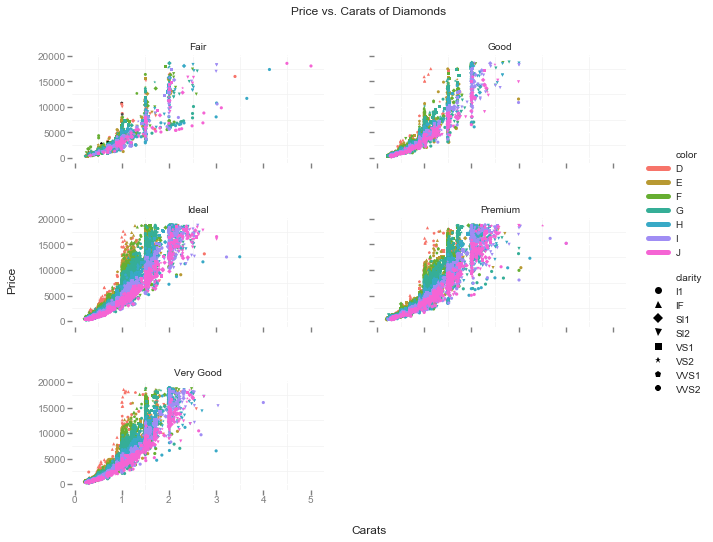

<ggplot: (299597099)>

In [6]:
# Create a faceted plot in ggplot using size, shape and color as well as facets.
#mpl.rcParams['figure.figsize'] = "15.0, 10.0"
#gsize = theme_matplotlib(rc={"figure.figsize": "15, 10"}, matplotlib_defaults=False)
#plt.figure(figsize=(20,15))
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"));
ggplot(diamonds_df, aes(x='carat', y='price', color='color', shape='clarity')) +\
    geom_point(size=10) +\
    theme_bw() +\
    facet_wrap("cut") +\
    xlab("Carats") +\
    ylab("Price") +\
    ggtitle("Price vs. Carats of Diamonds")

From the above plot, we can clearly see that the properties that define a better diamond (color J being the best and IF clarity being the best) are concentrated more on the right side for Cut = IDeal, Premium and Very Good, which means higher price, greater carat are for better quality diamonds.

In [27]:
# Before proceeding to the correlation check and model, let's transform the categorical variables
# Creating categories for the dimaond cuts
diamonds_df["cut_cat"] = 0
diamonds_df.loc[diamonds_df['cut']=='Fair','cut_cat']=0
diamonds_df.loc[diamonds_df['cut']=='Good','cut_cat']=1
diamonds_df.loc[diamonds_df['cut']=='Very Good','cut_cat']=2
diamonds_df.loc[diamonds_df['cut']=='Premium','cut_cat']=3
diamonds_df.loc[diamonds_df['cut']=='Ideal','cut_cat']=4

# Creating categories for the dimaond colors
diamonds_df["col_cat"] = 0
diamonds_df.loc[diamonds_df['color']=='J','col_cat']=0
diamonds_df.loc[diamonds_df['color']=='I','col_cat']=1
diamonds_df.loc[diamonds_df['color']=='H','col_cat']=2
diamonds_df.loc[diamonds_df['color']=='G','col_cat']=3
diamonds_df.loc[diamonds_df['color']=='F','col_cat']=4
diamonds_df.loc[diamonds_df['color']=='E','col_cat']=5
diamonds_df.loc[diamonds_df['color']=='D','col_cat']=6

# Creating categories for the dimaond clarity
diamonds_df["clr_cat"] = 0
diamonds_df.loc[diamonds_df['clarity']=='I1','clr_cat']=0
diamonds_df.loc[diamonds_df['clarity']=='SI2','clr_cat']=1
diamonds_df.loc[diamonds_df['clarity']=='SI1','clr_cat']=2
diamonds_df.loc[diamonds_df['clarity']=='VS2','clr_cat']=3
diamonds_df.loc[diamonds_df['clarity']=='VS1','clr_cat']=4
diamonds_df.loc[diamonds_df['clarity']=='VVS2','clr_cat']=5
diamonds_df.loc[diamonds_df['clarity']=='VVS1','clr_cat']=6
diamonds_df.loc[diamonds_df['clarity']=='IF','clr_cat']=7

diamonds_cp = diamonds_df.drop(['cut','color','clarity'], axis=1, inplace=False)
diamonds_cp.head()

,carat,depth,table,price,x,y,z,cut_cat,col_cat,clr_cat
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4,5,1
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3,5,2
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,5,4
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3,1,3
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,1


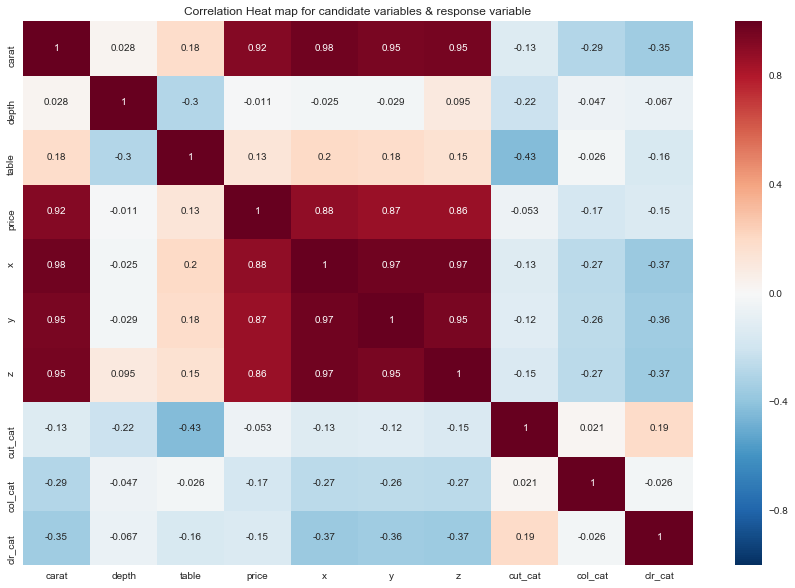

In [56]:
# Check the correlation among the variables
plt.subplots(figsize=(15,10))
sns.heatmap(diamonds_cp.corr(),annot=True).set_title('Correlation Heat map for candidate variables & response variable')

From the heatmap, price has very high positive correlation with carat, x, y and z (dimensions). Other variables like table have moderate correlation. The categorical variables do not correlate well with price. So, carat, table, x, y and z could be our explanatory variables. However, since x, y and z are also highly correlated with carat, we need to remove some of them to tackle multicollinearity issues. Hence, we are left only with carat and table.

In [73]:
# Separating the response (y) and explanatory (x) variables
#X = diamonds_cp[["carat", "depth", "table", "x", "y", "z", "cut_cat", "col_cat", "clr_cat"]].values
#X = diamonds_cp[["carat", "depth", "table","cut_cat", "col_cat", "clr_cat"]].values
X = diamonds_cp[["carat", "table"]].values
y = diamonds_cp["price"].values

In [74]:
# Splitting the dataset into test and training with 70% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [75]:
# Training the model with train dataset
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print('The Train set R-square value is', lm.score(X,y))

The Train set R-square value is 0.851005287395


In [76]:
# Testing the model with the test dataset
y_pred = lm.predict(X_test)
print('The Test set R-square value is', metrics.r2_score(y_test, y_pred))

The Test set R-square value is 0.85690433563
